### Parameter Estimation Stochastic Volatility Model Using Particle Filter And EM Algorithm

* Stochastic Volatility Model
* Parameter Estimation : Particle Filter & EM

### Parameter Estimation Stochastic Volatility Model Using Particle Filter And EM Algorithm

* Stochastics Volatility Model

\begin{align*}
&dS_t = \mu S_t dt + \sqrt V_t S_t dW^P_{1,t}\\
&dV_t = \kappa (\theta - V_t) dt + \sigma \sqrt V_t dW^P_{2,t}\\
&where\:Corr(dW^P_{1,t} , dW^P_{2,t}) = \rho
\end{align*}

* Discretization with annual parameters (log return)

\begin{align*}
&lnS_t-lnS_{t-1} = (\mu \Delta t - \frac{V_{t-1} \Delta t}{2}) + \sqrt{V_{t-1} \Delta t} \epsilon_1 \\
&(V_t - V_{t-1}) \Delta t = \kappa \Delta t (\theta \Delta t - V_{t-1} \Delta t) + \sigma \Delta t \sqrt{V_{t-1} \Delta t} (\rho \epsilon_1 + \sqrt{1 - \rho^2} \epsilon_2) \\
&where\:\epsilon_1 \sim N(0,1),\:\epsilon_2 \sim N(0,1),\: Corr(\epsilon_1,\epsilon_2) = 0
\end{align*}

* In terms of return $r_t$ and variance $V_t$

\begin{align*}
r_t\:&=\:(\mu-\frac{V_{t-1}}{2})+\sqrt{V_{t-1}}\epsilon_1 \\
V_t\:&=\:\kappa \theta+(1-\kappa) V_{t-1} + \rho \sigma \sqrt{V_{t-1}} \epsilon_1 + \sigma \sqrt{V_{t-1}(1 - \rho^2)}\epsilon_2
\end{align*}

* Particle Filter (Dynamic System) : Sequential Importance Resampling Filter Algorithm(SIR)

\begin{aligned}
&State \: equation \: : \: X_k = f(X_{k-1},W_k)\\
&Measure \: equation \: : \: Z_k = h(X_k,V_k)
\end{aligned}

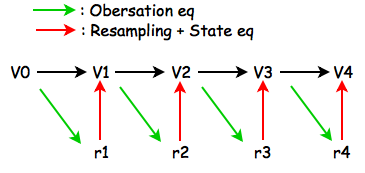

In [2]:
Image(filename = "/home/rory/SV_model_Particle_filter/Particle Filter process.png")

* The corresponding probability distribution functions. 
    * Weight : Resampling t - 1 $\mapsto$ t
$$p(r_t|V_{t-1})\:=\:\frac{1}{\sqrt{2 \pi V_{t-1}}}\:exp\{-\frac{(r_t - \mu + \frac{V_{t-1}}{2})^2}{2 V_{t-1}}\}$$
    * Transition probability:$$p(V_t|V_{t-1},r_t)=\frac{1}{\sqrt{2 \pi \sigma^2 (1 - \rho^2)V_{t-1}}}\:exp\{{- \frac{(V_t- \kappa \theta - (1-\kappa)V_{t-1}-\rho \sigma (r_t - \mu + \frac{V_{t-1}}{2}))^2}{2 \sigma^2 (1 - \rho^2) V_{t-1}}} \}$$

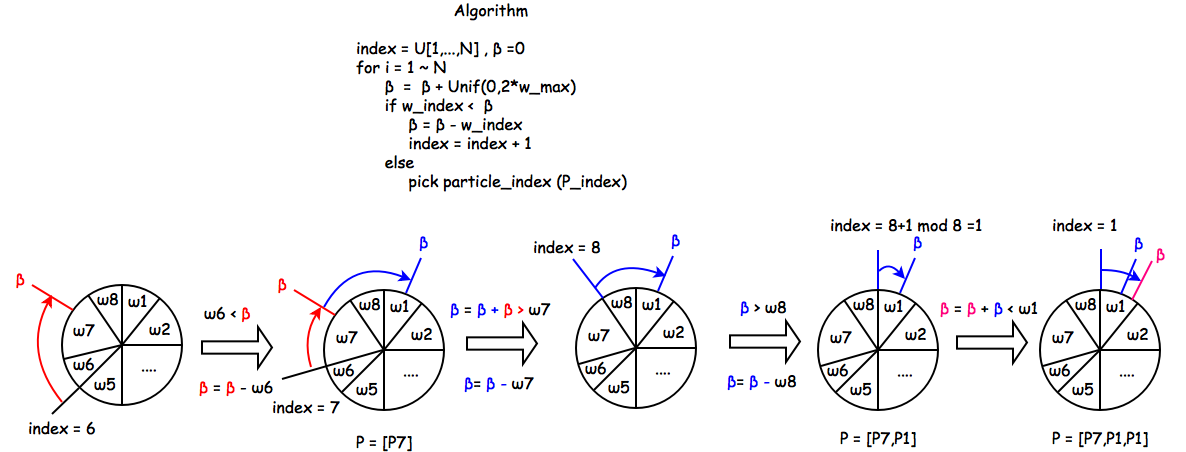

In [3]:
Image(filename = "/home/rory/SV_model_Particle_filter/resampling.png")

* Smoothing 
    * Weight : Resampling t $\mapsto$ t - 1
$$w_{t\:|\:t+1} = \frac{1}{\sqrt{2 \pi \sigma^2 (1 - \rho^2)V_{t-1}}}\:exp\{{- \frac{(V_t- \kappa \theta - (1-\kappa)V_{t-1}-\rho \sigma (r_t - \mu + \frac{V_{t-1}}{2}))^2}{2 \sigma^2 (1 - \rho^2) V_{t-1}}} \}$$

* EM Algorithm
    * Complete likelihood of $\{V_0,V_1,...,V_T,r_1,r_2,...,r_T\}$
    $$L(V_0,V_1,...,V_T,r_1,...r_T\:|\:\Omega)=f(V_0) \prod^T_{t=1}{f(V_t|V_{t-1},{r_t})\:f(r_t|V_{t-1})}$$
    * $E$ $step$ : Calculate the conditional expected value of the complete likelihood function with smooth particles.
    
    $$E(-2 log L(V_0,V_1,...,V_T,r_1,r_2,...,r_T\:|\:\Omega)\:|\:V_0,...,V_T,r_1,...,r_T)$$
 
    * $M$ $step$ : Minimum the expected likelihood function to estimate the model parameter $\Omega_i$.
    
    $$\Omega_i = argmin_{\Omega}\:E(-2\:log\:L(V_0,...V_T,r_1,...,r_T\:|\:\Omega\:|\:V_0,...,V_T,r_1,...r_T) $$

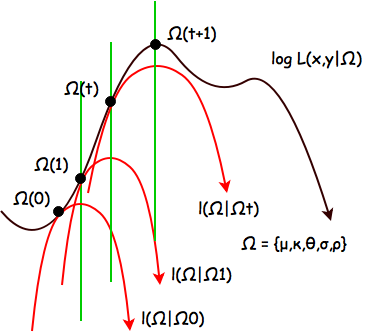

In [6]:
Image(filename = "/home/rory/SV_model_Particle_filter/EM.png")

### $Simulation$ $Code$

In [3]:
import pandas as pd 
import scipy as sp
import numpy as np
import random
import matplotlib.pyplot as plt
%pylab inline
from IPython.core.pylabtools import figsize
from scipy import optimize
from IPython.display import Image
import time

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
data = pd.read_csv('/home/rory/data_euasp3.csv', header = None)

In [3]:
class Particle_Filter_SV(object):
    
    def __init__(self, data, mu, kappa, theta, sigma, rho, N, T):
        
        self.data = data
        self.mu = mu
        self.kappa = kappa
        self.theta = theta
        self.sigma = sigma
        self.rho = rho        
        self.N = N
        self.T = T
        
    def Gaussian(self, y, mu_, sigma_):
        return (1/np.sqrt(2.0 * np.pi * sigma_ ** 2))* (np.exp(-0.5 * (((y - mu_) ** 2.0)/(sigma_ ** 2))))
    
    def MC_Filter(self):
        
        #particle initial
        particle_initial = np.array([self.theta for i in range(self.N)])
        weight_initial =np.array([1./self.N for i in range(self.N)])
        particle_time_seq = np.array([], dtype=np.float64)
        particle_time_seq = np.append(particle_time_seq ,particle_initial.tolist() ,axis = 0)
        
        for i in range(0, self.T, 1):
            
            if i == 0:
                particle_v = particle_time_seq
            elif i > 0:
                particle_v = (particle_time_seq[i])
                
            weight_mean = self.mu - particle_v / 2.0
            weight_sigma = np.sqrt(particle_v)
            weight = self.Gaussian(self.data[2].tolist()[i] ,weight_mean ,weight_sigma)
            weight_normal = weight / sum(weight)
            Resampling_Particle = self.Resampling(weight_normal ,particle_v , self.N)
            particle_move_ = self.particle_move(Resampling_Particle ,data[2].tolist()[i])
            #particle < 0 => sqrt : intr 
            particle_time_seq = np.maximum(np.vstack((particle_time_seq ,particle_move_)),0.0000001)
        
        return particle_time_seq
    
    def particle_move(self ,v ,r):
        
        v_ = (1 - self.kappa) * v + self.kappa * self.theta\
            + self.rho * self.sigma * (r - self.mu + (0.5) * v)\
            + self.sigma * np.sqrt(v * (1 - self.rho ** 2)) * np.random.normal(0,1,N)        
        return v_
    
    def MC_Filter_smoothing(self):
        
        smooth_particle_time_seq = np.zeros((self.T+1 ,self.N))
        no_smooth_particle_time_seq = self.MC_Filter()
        smooth_particle_time_seq[self.T] = no_smooth_particle_time_seq[self.T]#[np.random.randint(0,self.N,self.N)]
        
        for i in range(0,self.N,1):
            for k in range(self.T,0,-1):
                
                #transition probability p(x_t | x_(t-1) ,y_t)
                particle_mean_ = (1 - self.kappa) * no_smooth_particle_time_seq[k-1]\
                               + self.kappa * self.theta + self.rho * self.sigma\
                               * (data[2].tolist()[k-1] - self.mu + (0.5) * no_smooth_particle_time_seq[k-1])
                particle_std_ = self.sigma * np.sqrt((1 - self.rho ** 2) * no_smooth_particle_time_seq[k-1])
                smooth_particle_ = smooth_particle_time_seq[k][i]
                measurable_particle_function = self.Gaussian(smooth_particle_,particle_mean_,particle_std_)
                weight_ = measurable_particle_function / sum(measurable_particle_function)
                
                #resampling 
                index = int(random.random() * self.N)
                beta = 0.0
                max_w = max(weight_)
                beta = random.random() * 2.0 * max_w
                while beta > weight_[index]:
                    beta -= weight_[index]
                    index = (index + 1) % self.N
                smooth_particle_time_seq[k-1][i] = no_smooth_particle_time_seq[k-1][index]  
        
        return smooth_particle_time_seq,no_smooth_particle_time_seq  
    
    def EM_Algorithm_Likelihood(self,para): #need to give x(particle),y(log return)
        # para[0] : mu , para[1] : kappa , para[2] : theta , para[3] : sigma , para[4] : rho      
        Log_likelihood_tra_1 = 0
        Log_likelihood_tra_2 = 0
        Log_likelihood_obser_1 = 0
        Log_likelihood_obser_2 = 0
        for i in range(1,len(y)+1,1):
            Log_likelihood_tra_1 += np.mean(np.log(2 * np.pi * (para[3] ** 2) * (1 - (para[4] ** 2)) * x[i-1]))
            Log_likelihood_tra_2 += np.mean(((x[i] - para[1] * para[2] - (1 - para[1]) * x[i-1] - para[4] * para[3]\
                                              * (y[i-1] - para[0] + 0.5 * x[i-1])) ** 2)/((para[3] ** 2) * (1 - (para[4] ** 2))\
                                              * x[i-1]))
            Log_likelihood_obser_1 += np.mean(np.log(2.0 * np.pi * x[i-1]))
            Log_likelihood_obser_2 += np.mean(((y[i-1] - para[0] + 0.5 * x[i-1]) ** 2)/(x[i-1]))
        return Log_likelihood_tra_1 + Log_likelihood_tra_2 + Log_likelihood_obser_1 + Log_likelihood_obser_2
    
    def Resampling(self ,w ,x ,N):
        
        resampling_particle = []
        index = int(random.random() * N)
        beta = 0.0
        max_w = max(w)
        
        for i in range(N):
            beta += random.random() * 2.0 * max_w
            while beta > w[index]:
                beta -= w[index]
                index = (index + 1) % N
            resampling_particle.append(x[index])
            
        return np.array(resampling_particle)    

In [7]:
if __name__ == "__main__":
    
    parameter_matrix = np.array([], dtype=np.float64)
    hidden_latent_varible_mean = []
    hidden_latent_varible_std = []
    hidden_latent_varible = []
    
    hidden_latent_varible_mean_nosmooth = []
    hidden_latent_varible_std_nosmooth = []
    hidden_latent_varible_nosmooth = []
    
    likelihood = []
    # initial value
    mu, kappa, theta, sigma, rho = np.array([0, 0.1, 0.002, 0.005, -0.2])
    parameter_matrix = np.append(parameter_matrix ,[mu, kappa, theta, sigma, rho] ,axis = 0)
    Max_Iter_number = 10
    N = 300
    T = data.shape[0]
    # Algorithm
    Iter_number = 0
    while Iter_number < Max_Iter_number:
        start = time.time()
        Algorithm = Particle_Filter_SV(data, mu, kappa, theta, sigma, rho ,N ,T)
        x,no_s = Algorithm.MC_Filter_smoothing()
        y = data[2]
        
        hidden_latent_varible.append(x.tolist())
        hidden_latent_varible_mean.append(x.mean(axis = 1).tolist()) 
        hidden_latent_varible_std.append(x.std(axis = 1).tolist()) 
        
        hidden_latent_varible_nosmooth.append(no_s.tolist())
        hidden_latent_varible_mean_nosmooth.append(no_s.mean(axis = 1).tolist())
        hidden_latent_varible_std_nosmooth.append(no_s.std(axis = 1).tolist())
        
        # EM
        new_parameter = optimize.fmin(Algorithm.EM_Algorithm_Likelihood, [mu, kappa, theta, sigma, rho])  
        parameter_matrix = np.vstack((parameter_matrix ,new_parameter))
        mu, kappa, theta, sigma, rho = new_parameter
        likelihood.append(Algorithm.EM_Algorithm_Likelihood([mu, kappa, theta, sigma, rho]))
        end = time.time()
        print Algorithm.EM_Algorithm_Likelihood([mu, kappa, theta, sigma, rho])
        print 'mu = %s ,kappa = %s ,theta = %s ,sigma = %s ,rho = %s'%(mu, kappa, theta, sigma, rho)
        print 'Time = %s'%(end - start)
        print "---------------------------------------------------------"
        
        Iter_number += 1

Optimization terminated successfully.
         Current function value: -10651.650747
         Iterations: 135
         Function evaluations: 224
-10651.6507472
mu = 0.00155088096055 ,kappa = 0.0565139131412 ,theta = 0.00184770819765 ,sigma = 0.00529581572836 ,rho = -0.221558447853
Time = 44.8743469715
---------------------------------------------------------
Optimization terminated successfully.
         Current function value: -10953.104385
         Iterations: 166
         Function evaluations: 270
-10953.1043851
mu = 0.0014890568658 ,kappa = 0.0291368086483 ,theta = 0.00148195254339 ,sigma = 0.00565146759753 ,rho = -0.243497632616
Time = 46.2310700417
---------------------------------------------------------
Optimization terminated successfully.
         Current function value: -11077.192319
         Iterations: 151
         Function evaluations: 244
-11077.1923186
mu = 0.00115195373164 ,kappa = 0.0272804847522 ,theta = 0.00145976356523 ,sigma = 0.006018403531 ,rho = -0.236804403371

### Likelihood

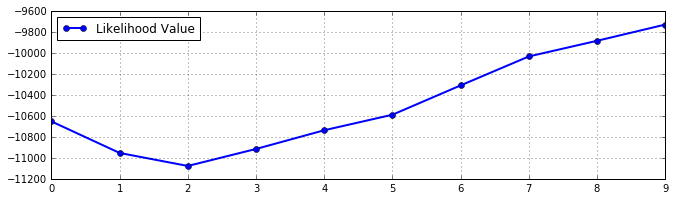

In [8]:
plt.figure(figsize=(11, 3))
plt.plot(likelihood,'-o',label = 'Likelihood Value',lw = 2)
plt.grid()
plt.legend(loc = 0)

### Nosmoothing

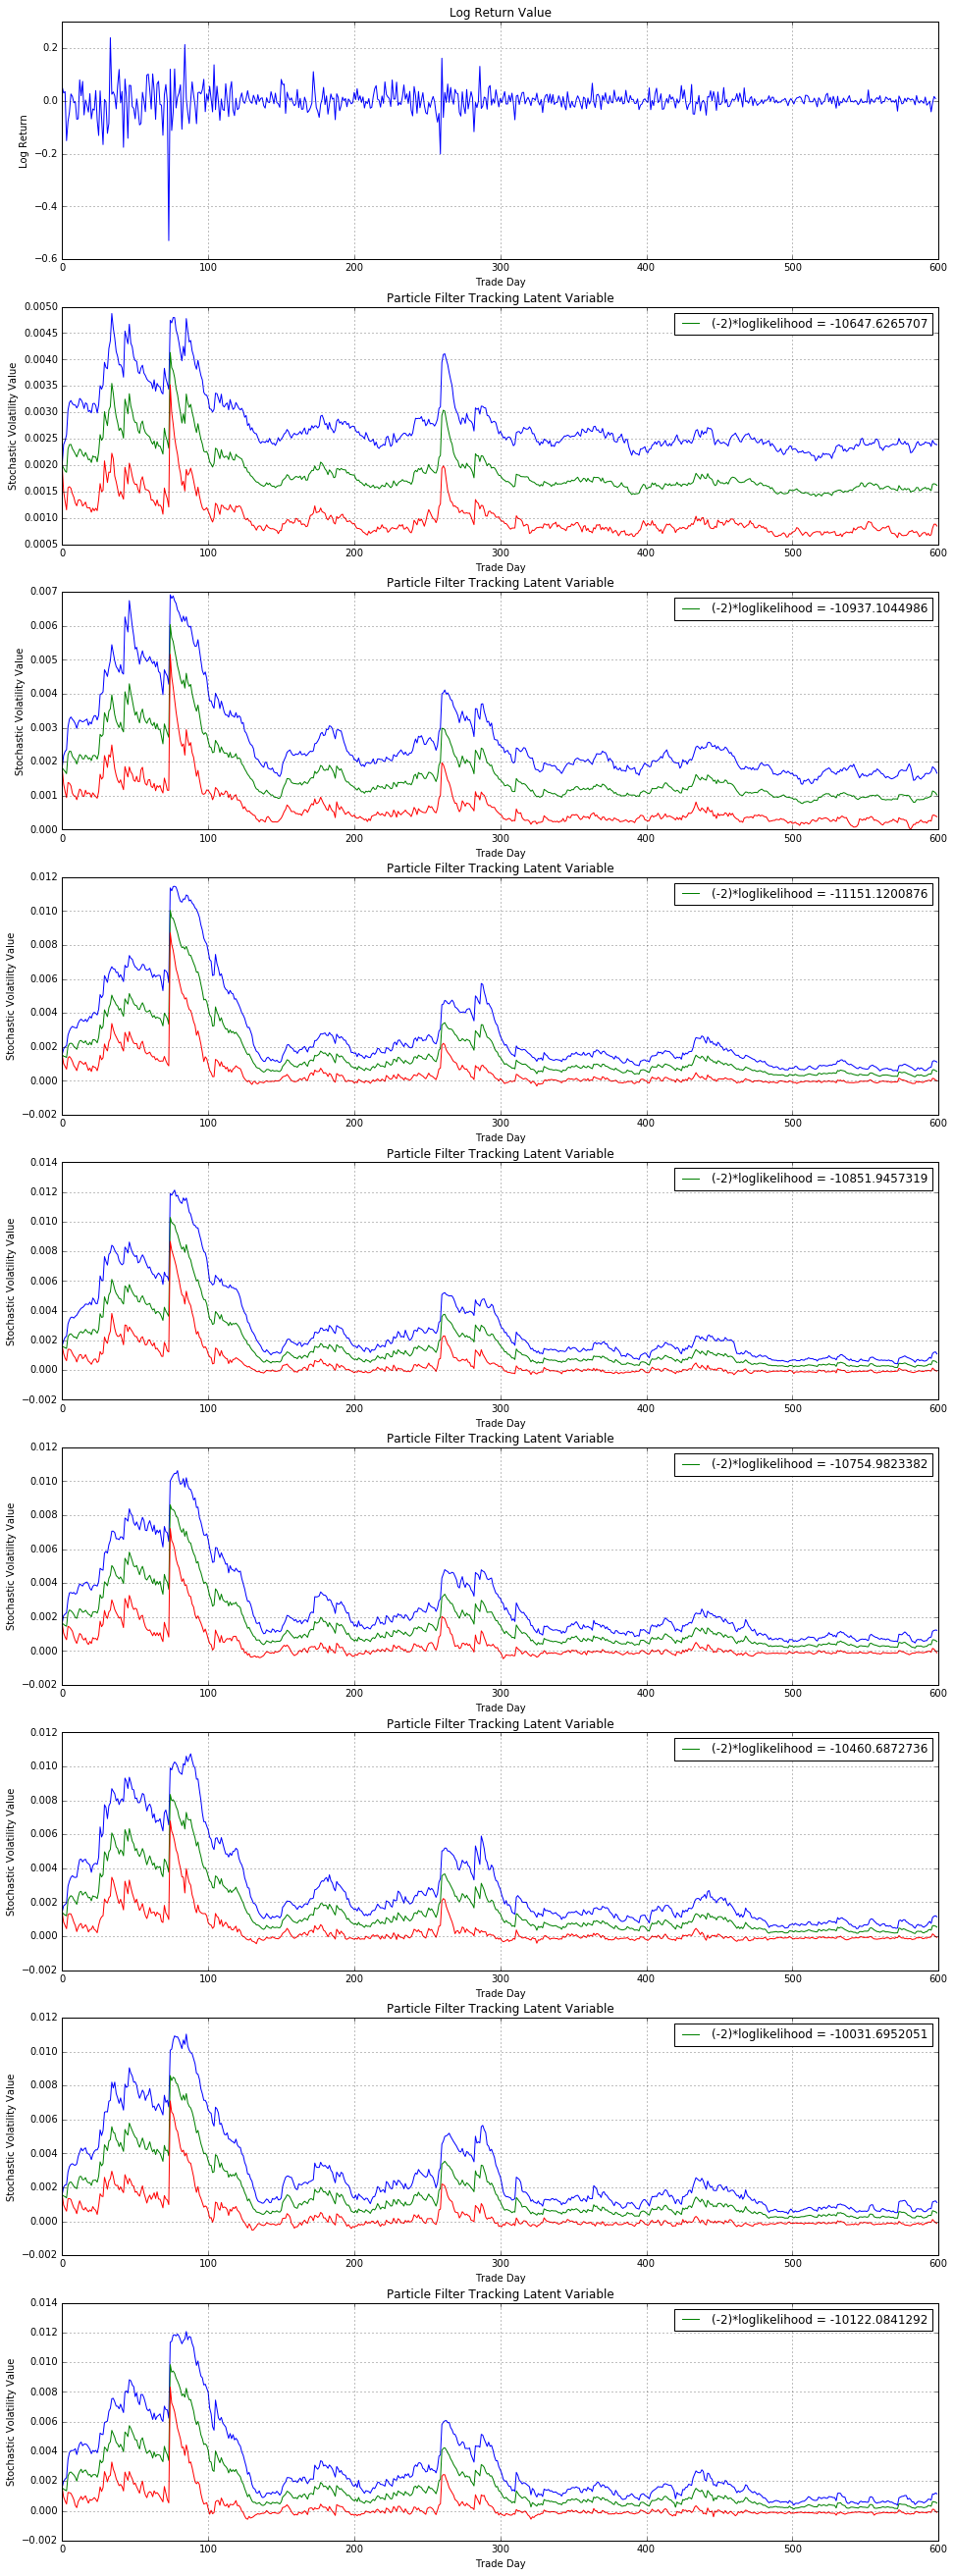

In [7]:
plt.figure(figsize=(16, 46))
plt.subplot(911)
plt.xlabel('Trade Day')
plt.ylabel('Log Return')
plt.title('Log Return Value')
plot(data[2])
plt.grid()

for i in range(0,len(hidden_latent_varible_mean)-2,1):
    
    plt.subplot(911+i+1)
    plt.xlabel('Trade Day')
    plt.ylabel('Stochastic Volatility Value')
    plt.title('Particle Filter Tracking Latent Variable')
    plt.plot(array(hidden_latent_varible_mean_nosmooth[i]) + 1.96 * array(hidden_latent_varible_std_nosmooth[i]))
    plt.plot(hidden_latent_varible_mean_nosmooth[i],label = '(-2)*loglikelihood = %s'%(likelihood[i]))
    plt.plot(array(hidden_latent_varible_mean_nosmooth[i]) - 1.96 * array(hidden_latent_varible_std_nosmooth[i]))
    plt.grid()
    plt.legend(loc = 0)

### smoothing

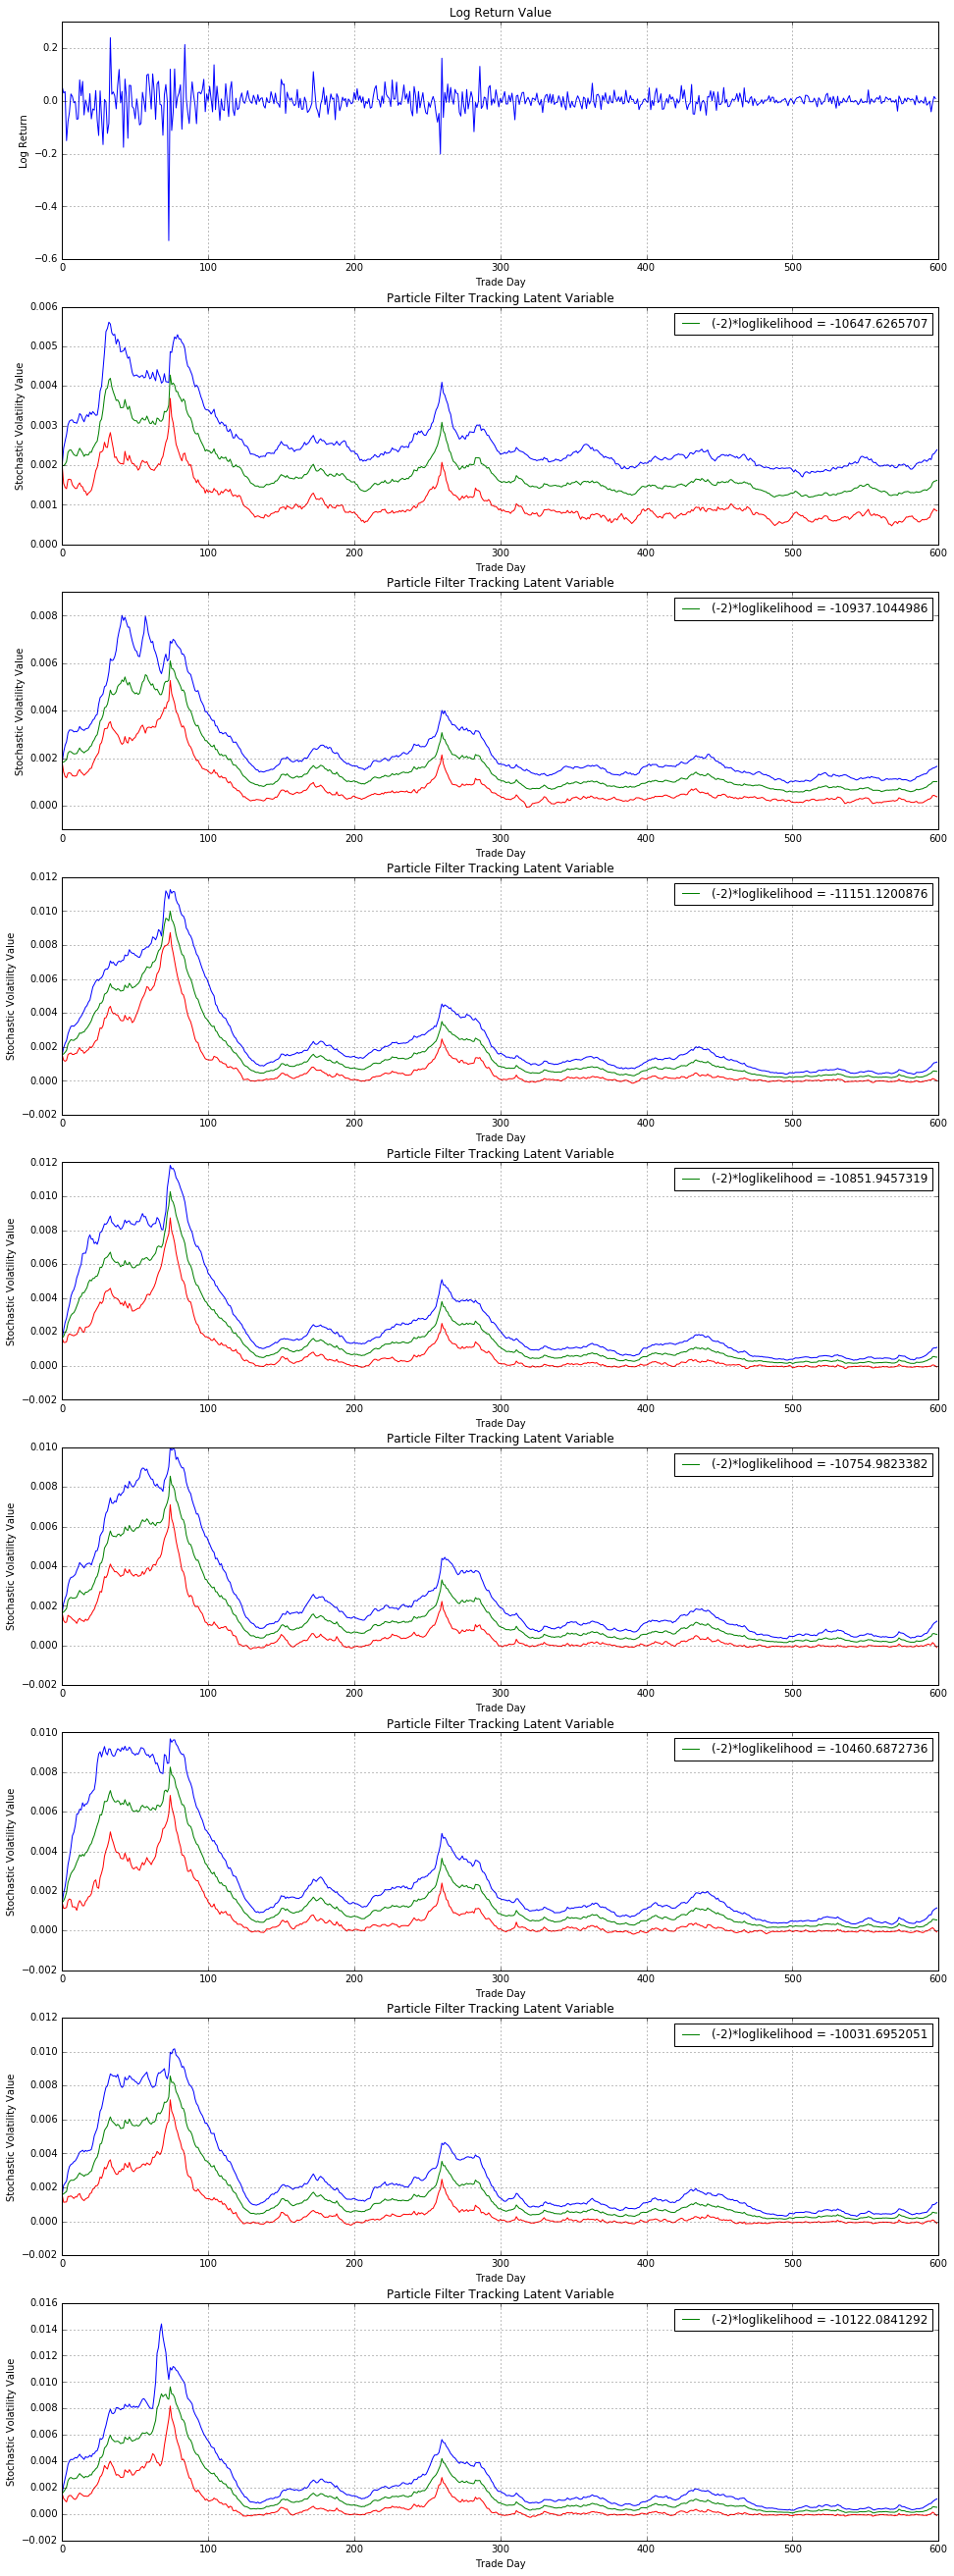

In [8]:
plt.figure(figsize=(16, 46))
plt.subplot(911)
plt.xlabel('Trade Day')
plt.ylabel('Log Return')
plt.title('Log Return Value')
plot(data[2])
plt.grid()

for i in range(0,len(hidden_latent_varible_mean)-2,1):
    
    plt.subplot(911+i+1)
    plt.xlabel('Trade Day')
    plt.ylabel('Stochastic Volatility Value')
    plt.title('Particle Filter Tracking Latent Variable')
    plt.plot(array(hidden_latent_varible_mean[i]) + 1.96 * array(hidden_latent_varible_std[i]))
    plt.plot(hidden_latent_varible_mean[i],label = '(-2)*loglikelihood = %s'%(likelihood[i]))
    plt.plot(array(hidden_latent_varible_mean[i]) - 1.96 * array(hidden_latent_varible_std[i]))
    plt.grid()
    plt.legend(loc = 0)

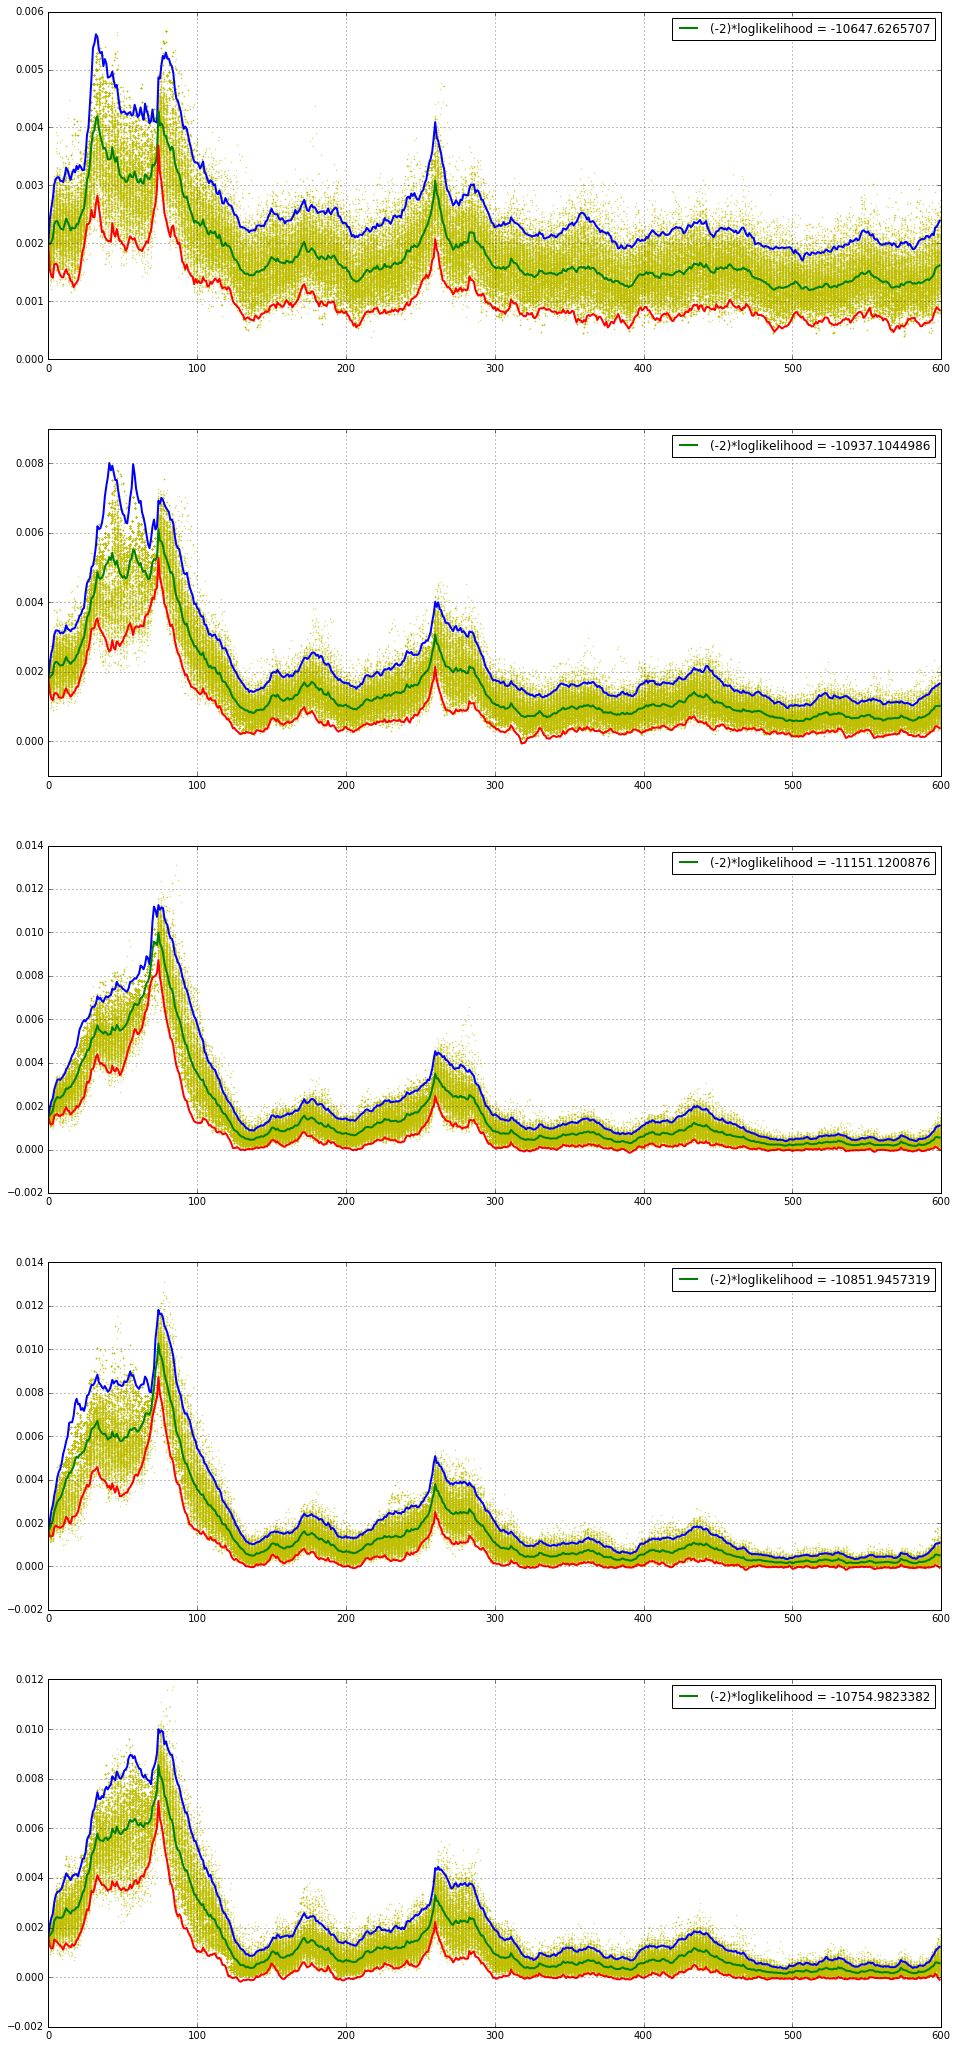

In [16]:
plt.figure(figsize=(16, 66))

for i in range(0,len(hidden_latent_varible_mean)-5,1):
    plt.subplot(911+i)
    plt.plot([k for k in range(0,600,1)],array(hidden_latent_varible)[i],'o',color = 'y', mew = 0, ms=1.5,alpha=0.5);grid(True)
    plt.plot(array(hidden_latent_varible_mean[i]) + 1.96 * array(hidden_latent_varible_std[i]),color = 'b',lw = 2)
    plt.plot(hidden_latent_varible_mean[i],label = '(-2)*loglikelihood = %s'%(likelihood[i]),color = 'g',lw = 2)
    plt.plot(array(hidden_latent_varible_mean[i]) - 1.96 * array(hidden_latent_varible_std[i]),color = 'r',lw = 2)
    plt.legend(loc = 0)

* Another Model
    * SV-MJ
    * SV-MJ-IJV
    * SV-MJ-CJV
    * SV-DEJ
    * SV-DEJ--IJV
    * SV-DEJ--CJV
    * ......